# Lesson 4A: Implementing Controller (Pole Stabilization)

This notebook is designed to run in Google Colab or local Jupyter.

**Colab steps:** Open the notebook, run the setup cell below, then run cells top-to-bottom.

## Learning Objectives
- Select a baseline controller (P, PD, PID) for pole stabilization.
- Tune gains to meet basic stability and response goals.
- Evaluate performance via plots and metrics.

### Parameters (update as needed)
| Symbol | Meaning | Example |
| --- | --- | --- |
| m_c | Cart mass | 0.5 kg |
| m_p | Pendulum mass | 0.2 kg |
| l | Pendulum length | 0.3 m |
| g | Gravity | 9.81 m/s^2 |
| dt | Sample time | 0.01 s |

---
## Lesson Content

In [1]:
# Install required packages (Colab)
!pip -q install numpy scipy matplotlib


## Control is tradeoff management (P/PD)
Set constraints before tuning:
- Maximum overshoot
- Settling time
- Maximum force

Tasks:
- Show a case where P-only control is too slow or fails to stabilize.
- Add D and note the improvement in damping.
- Inject measurement noise and observe D amplifying noise.

Deliverable: a short design justification (not just gains).


The dynamics reduce to:
$$
\dot{X} = AX.
$$

### Eigenvalue Analysis
The stability of the system depends on the eigenvalues of the matrix $ A $. Solve the characteristic equation:
$$
\det(\lambda I - A) = 0.
$$


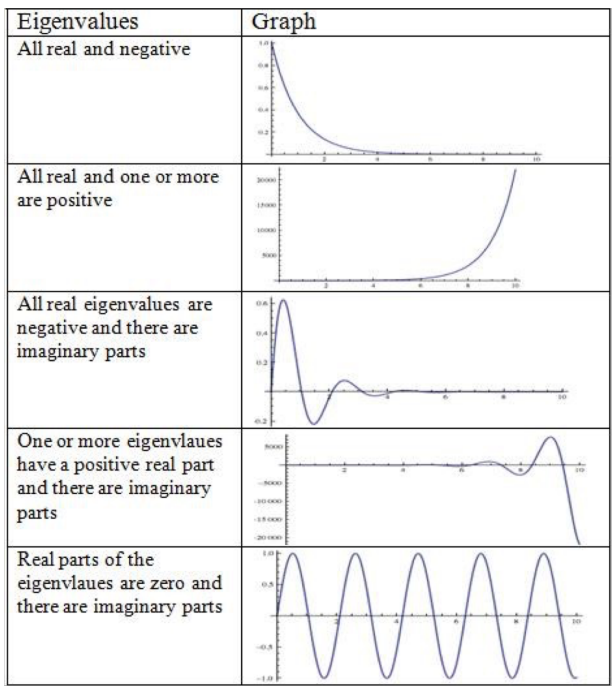

[ 0.          0.          4.64564312 -4.64564312]
[0.+0.j         0.+0.j         0.+4.64564312j 0.-4.64564312j]


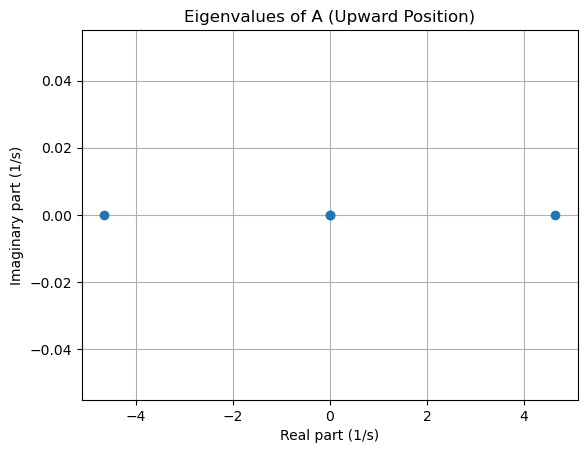

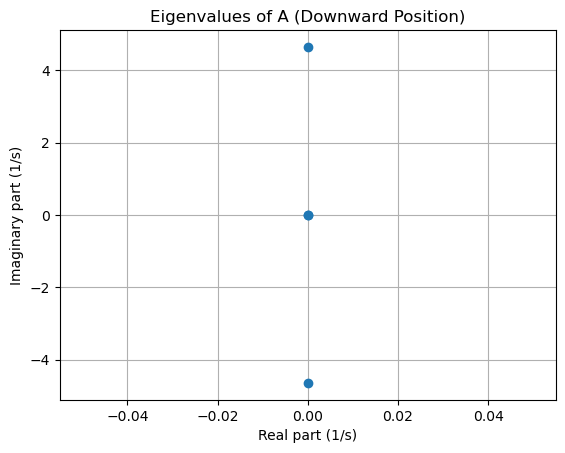

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define system parameters
m_c = 1  # mass of the cart
m_p = 0.1  # mass of the pendulum
L = 0.5  # length of the pendulum
g = 9.81  # acceleration due to gravity

# Define the A matrix for the upward position
A_up = np.array([
    [0, 1, 0, 0],
    [0, 0, -m_p * g / m_c, 0],
    [0, 0, 0, 1],
    [0, 0, (m_c + m_p) * g / (L * m_c), 0]
])

# Calculate eigenvalues for the upward position
e_up = np.linalg.eigvals(A_up)
print(e_up)

# Plot eigenvalues for the upward position
plt.figure()
plt.plot(np.real(e_up), np.imag(e_up), 'o')
plt.title('Eigenvalues of A (Upward Position)')
plt.xlabel('Real part (1/s)')
plt.ylabel('Imaginary part (1/s)')
plt.grid(True)


# Define the A matrix for the downward position
A_down = np.array([
    [0, 1, 0, 0],
    [0, 0, -m_p * g / m_c, 0],
    [0, 0, 0, 1],
    [0, 0, -(m_c + m_p) * g / (L * m_c), 0]
])

# Calculate eigenvalues for the downward position
e_down = np.linalg.eigvals(A_down)
print(e_down)

# Plot eigenvalues for the downward position
plt.figure()
plt.plot(np.real(e_down), np.imag(e_down), 'o')
plt.title('Eigenvalues of A (Downward Position)')
plt.xlabel('Real part (1/s)')
plt.ylabel('Imaginary part (1/s)')
plt.grid(True)

plt.show()

**Expected output:**
- Upward equilibrium shows at least one eigenvalue with positive real part; downward shows negative real parts.

For a linear system described by:

$$
\dot{x}(t) = A x(t)
$$

The solution is in the form:

$$
x(t)=ce^\lambda t
$$

where $c$ is a constant and $e^{\lambda t}$ represent the growth or decay of the state over time.

If $\lambda > 0 $, system is unstable and grows exponentially with time.

if $\lambda = 0$, system is marginally stable.

If $\lambda < 0 $, system is stable and decays exponentially to equilibrium.

# Implement a Control Strategy (Pole Stabilization)
Learn how to control the system and stabilize the pole.

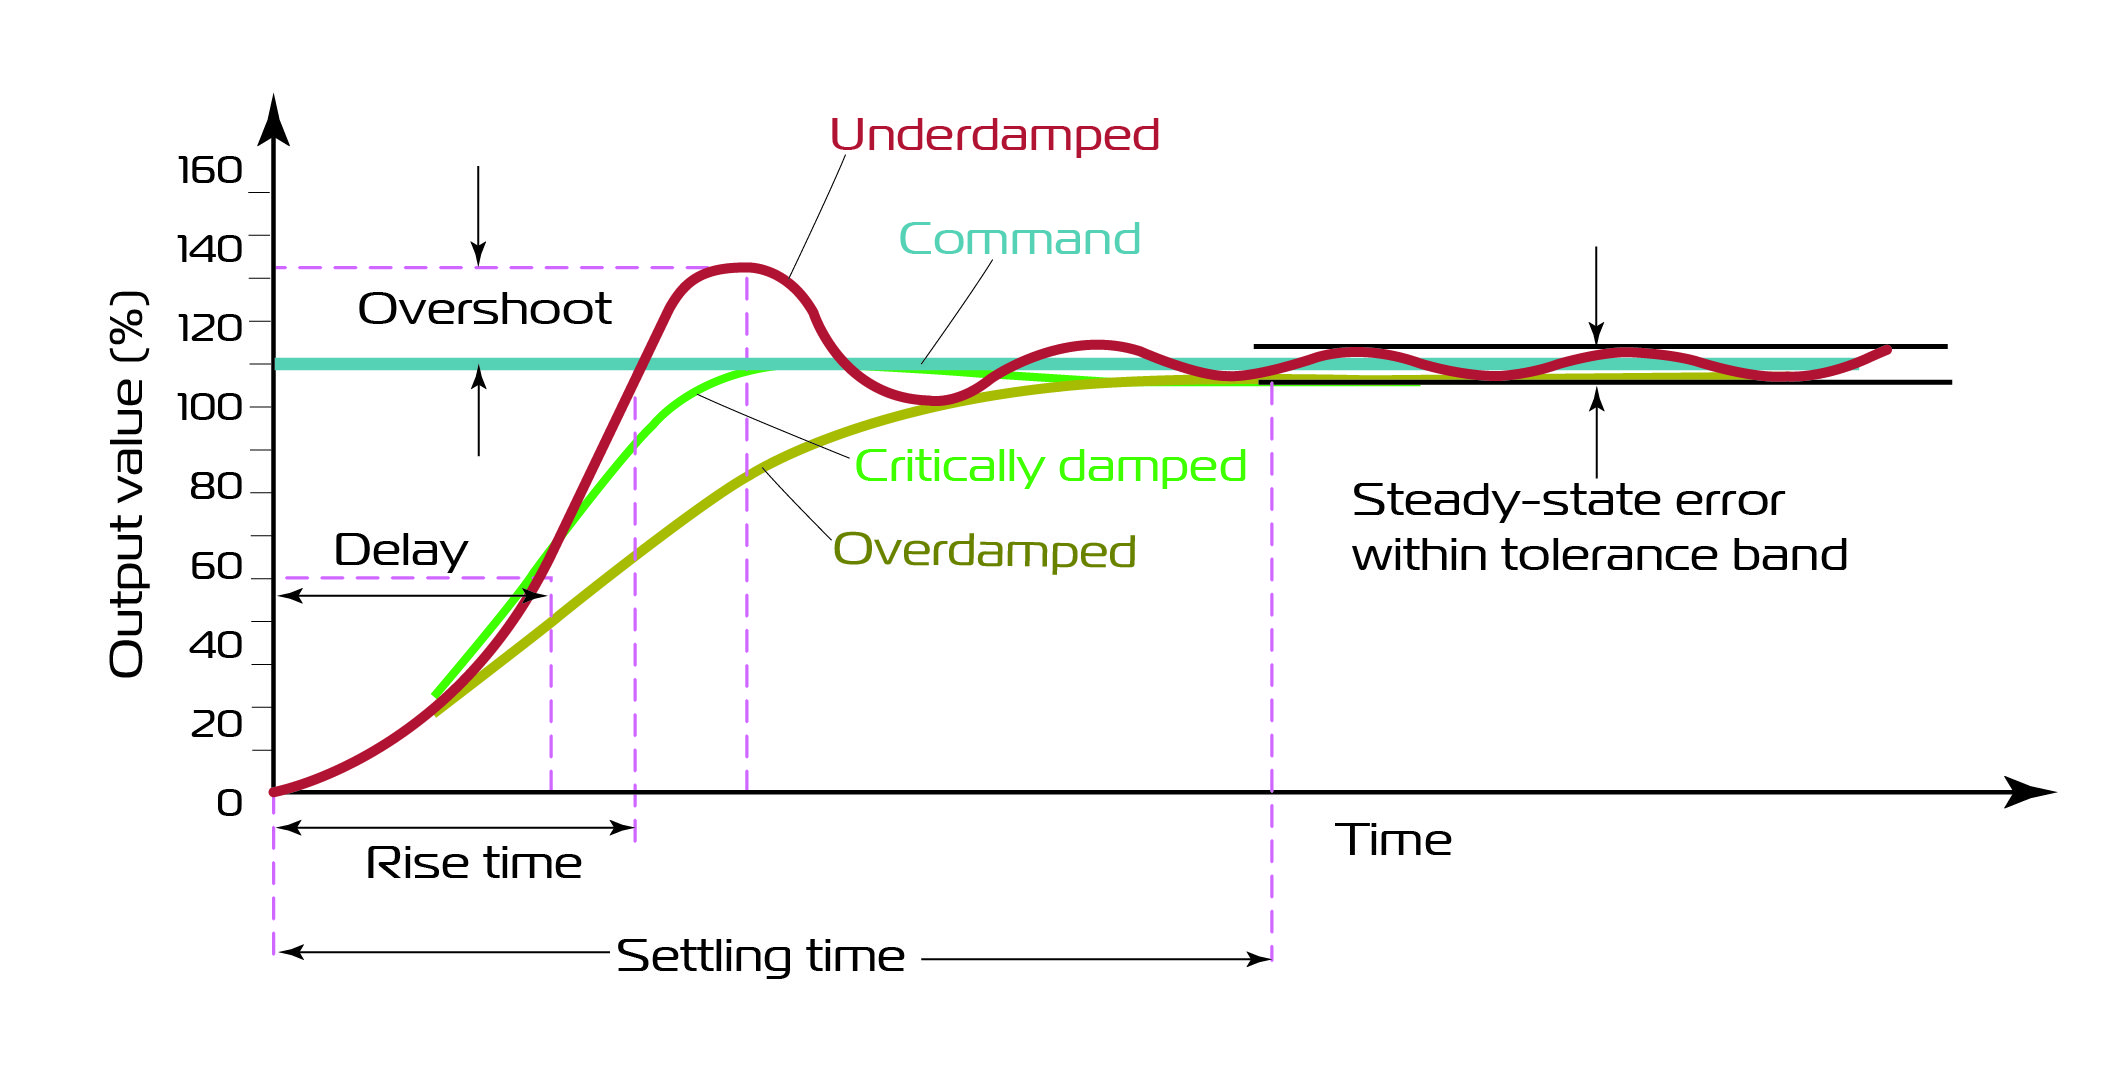

## The Proportional-Integral-Derivative (PID) Controller
A **Proportional-Integral-Derivative (PID) Controller** is a widely used feedback control system. It adjusts the output of a process to achieve a desired setpoint by minimizing the error between the setpoint and the process variable. The PID controller has three key components:

- **Proportional (P):** Provides a correction proportional to the current error, improving response speed..

- **Integral (I):** Accumulates past errors over time to address steady-state error, ensuring long-term accuracy.

- **Derivative (D):** Responds to the rate of error change, predicting future trends to enhance system stability and reduce overshooting.

By tuning the gains of each component, the PID controller can achieve a balance between speed, stability, and accuracy in dynamic systems.

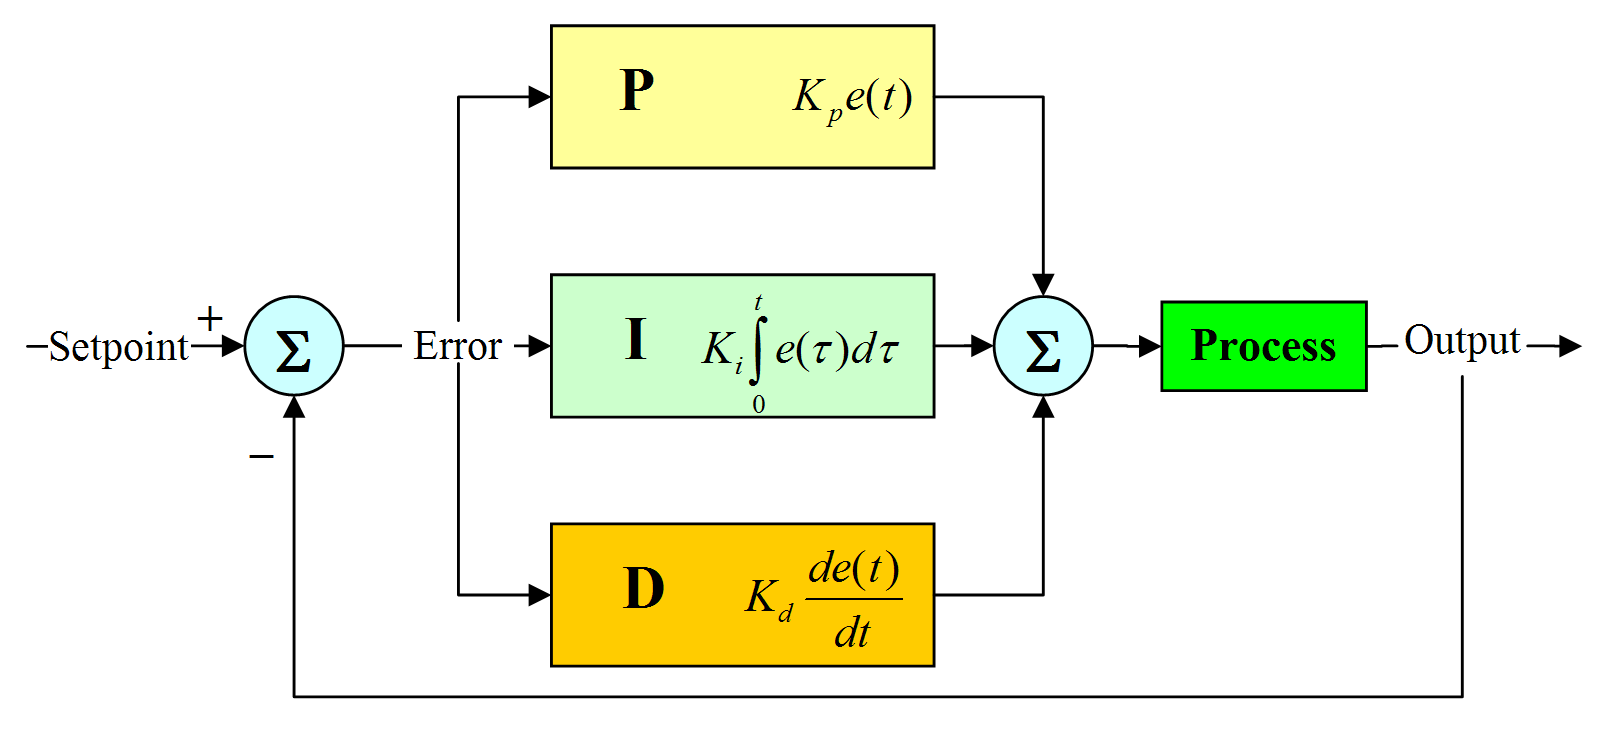

## **Task**: Implement a Simple P, PD and PID Controller (Till end of lesson)
-  Slowly tune up the Gain and observe how the system responds. Comment on the system stability and oscillation, with reference to key performance metrics, e.g. rise time, overshoot, steady state error.
- Experiment and balance between response speed and stability.

In [3]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import math
from pathlib import Path

class InvertedPendulum:
    def __init__(self, dt=0.02):
        # System constants
        self.gravity = 9.8        # Acceleration due to gravity (m/s^2)
        self.mass_cart = 1.0      # Mass of the cart (kg)
        self.mass_pole = 0.1      # Mass of the pole (kg)
        self.length = 0.5         # Length of the pole (m)
        self.dt = dt              # Time step (s)

        # State variables: [cart position, cart velocity, pole angle, pole angular velocity]
        self.state = np.zeros(4)

        self.save_dir = 'temp/'
        Path(self.save_dir).mkdir(parents=True, exist_ok=True)

    def reset(self):
        """Resets the system state to a small random initial condition."""
        self.state = np.random.uniform(low=-0.05, high=0.05, size=(4,))
        return self.state

    def step(self, force):
        """
        Takes an action (force) and updates the system state.
        Args:
            force (float): Force applied to the cart (N)
        Returns:
            np.array: Updated state [cart position, cart velocity, pole angle, pole angular velocity]
        """
        x, x_dot, theta, theta_dot = self.state

        # Constants for easier calculations
        total_mass = self.mass_cart + self.mass_pole
        pole_mass_length = self.mass_pole * self.length
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)

        # # Equations of motion
        # temp = (force + pole_mass_length * theta_dot**2 * sin_theta) / total_mass
        # theta_acc = (self.gravity * sin_theta - cos_theta * temp) / (
        #     self.length * (4.0 / 3.0 - self.mass_pole * cos_theta**2 / total_mass)
        # )

        # x_acc = temp - pole_mass_length * theta_acc * cos_theta / total_mass

        x_acc = (force + self.mass_pole*sin_theta*(self.length*theta_dot**2 - self.gravity * cos_theta)) / (self.mass_cart + self.mass_pole * sin_theta**2)
        theta_acc = (-1*force * cos_theta - self.mass_pole*self.length*theta_dot**2*sin_theta*cos_theta + (self.mass_cart + self.mass_pole)*self.gravity*sin_theta) /  (self.length*(self.mass_cart + self.mass_pole * sin_theta**2))

        # Update state using Euler integration
        x += self.dt * x_dot
        x_dot += self.dt * x_acc
        theta += self.dt * theta_dot
        theta_dot += self.dt * theta_acc

        self.state = np.array([x, x_dot, theta, theta_dot])
        return self.state

    def render(self, file_idx=0, title="Inverted Pendulum"):
        """
        Plots the cart and pole position with a specified title for Colab.

        Args:
            title (str): Title to display on the plot.
        """
        x, _, theta, _ = self.state

        # Cart dimensions
        cart_width = 0.3
        cart_height = 0.2

        # Pole position
        pole_x = x + self.length * np.sin(theta)
        pole_y = self.length * np.cos(theta)

        # Clear previous output
        clear_output(wait=True)

        # Create a new figure
        plt.figure(figsize=(8, 4))
        plt.xlim(-2, 2)
        plt.ylim(-1, 1)
        plt.grid()

        # Draw the cart
        cart_rect = Rectangle((x - cart_width / 2, -cart_height / 2), cart_width, cart_height, color="blue")
        plt.gca().add_patch(cart_rect)

        # Draw the pole
        plt.plot([x, pole_x], [0, pole_y], color="red", linewidth=2)

        # Draw the pivot point
        plt.plot(x, 0, 'ko', markersize=5)

        # Set the title
        plt.title(title)

        # # Save figure
        # plt.savefig(self.save_dir + str(file_idx) + '.png')

        # Display the updated plot
        plt.show()


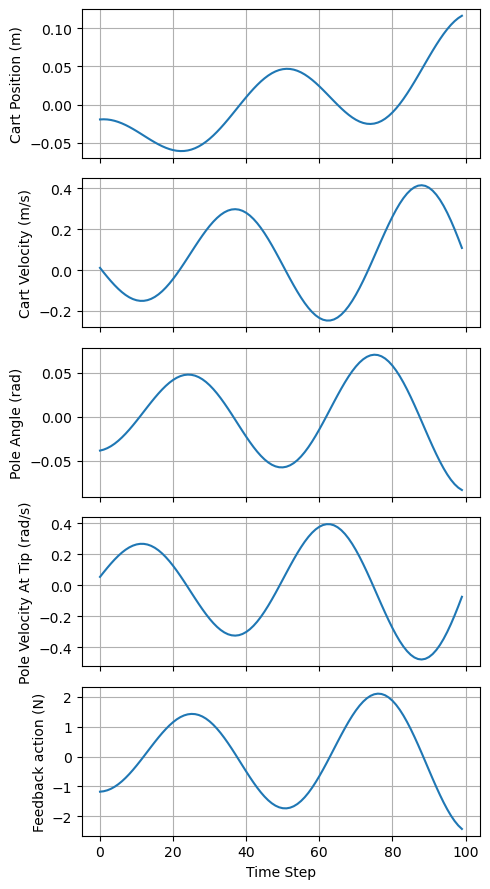

In [4]:
# Create an instance of the inverted pendulum system
pendulum = InvertedPendulum()

# Reset the system to a random initial state
states = pendulum.reset()

# ### TODO: Vary initial pole position (state[2]) & velocity (state[3]) here.
# pendulum.state[0] = 0.0
# pendulum.state[1] = 0.0
# pendulum.state[2] = 0.02
# pendulum.state[3] = 0.0


states_list = [] # List to save states for plot later
action_list = [] # List to save actions for plot later

SIMULATION_STEPS = 100 # number of time steps to take in simulation

Kp = 30 # Propotional Gain
setpoint = 0.0 # Desired pole angle

# Simulate the system with random forces and render the results
for step in range(SIMULATION_STEPS):

    error = setpoint - states[2] # compute the error between desired pole angle to observed pole angle

    action = -1*(Kp * error) # P controller that sets control action based on Kp*error

    states = pendulum.step(action) # Apply action on cart

    # Saving for plots later
    states_list.append(states)
    action_list.append(action)

    ## Switching off display
    # pendulum.render(title=f"Step {step + 1}: Force = {action:.2f} N") # Display function
    # print(states)


num_states = len(states_list[0])  # Number of observatioSns per step
fig, axes = plt.subplots(num_states + 1, 1, sharex=True, figsize=(5, 2 * num_states + 1))

# Y-axis labels
y_labels = ["Cart Position (m)", "Cart Velocity (m/s)", "Pole Angle (rad)", "Pole Velocity At Tip (rad/s)"]

for i in range(num_states):
    states_values = [s[i] for s in states_list]
    axes[i].plot(states_values)
    axes[i].set_ylabel(y_labels[i])
    axes[i].grid(True)

# plotting control signal
axes[-1].plot(action_list)
axes[-1].set_ylabel('Feedback action (N)')
axes[-1].grid(True)

axes[-1].set_xlabel("Time Step")
plt.tight_layout()
plt.show()

## Tradeoff reflection
Summarize how P and D affected speed, overshoot, and noise sensitivity for your final gains.


---
## Checkpoints
- Closed-loop response stabilizes the pole near the target.
- Plots show acceptable overshoot and settling time.

## Common Pitfalls
- Integral windup when limits or saturation are ignored.
- Derivative noise amplification without filtering.